In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from skimage.filters import threshold_multiotsu
import os
import porespy as ps
from tifffile import imwrite
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf


# initialize the config
initialize(config_path=f"../config/ex6")
cfg_dataset = compose(config_name="dataset")
cfg_vqgan = compose(config_name="vqgan")

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


In [2]:
def np_to_tif(img,f_name):
    '''
    convert numpy to tif
    '''

    img_save = (img * 255).astype('uint8')
    # Save the 3D array as a 3D tif
    imwrite(f_name, img_save)

def tif_to_np(f_name):
    '''
    convert tif to numpy
    '''
    img = imread(f_name)
    img = img.astype('float32')/255
    return img>0.5

def clean_img(img_t):
    '''
    2  3^3 median image filter
    3 Otsu binary segmentation
    https://homepages.inf.ed.ac.uk/rbf/HIPR2/median.htm
    https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_multiotsu.html
    '''

    thresholds = threshold_multiotsu(img_t,classes=2)
    # from the threshold we separate regions
    img_t = np.digitize(img_t, bins=thresholds)

    return img_t


def crop_subset_image(i, j, k, original_image):
    if original_image.shape != (128, 128, 128):
        raise ValueError("Original image must have dimensions (128, 128, 128).")
    
    if i not in [0, 1] or j not in [0, 1] or k not in [0, 1]:
        raise ValueError("Indices i, j, k must each be 0 or 1.")
    
    # Calculate start indices for cropping
    start_i = i * 64
    start_j = j * 64
    start_k = k * 64
    
    # Crop and return the subset
    subset_image = original_image[start_i:start_i+64, start_j:start_j+64, start_k:start_k+64]
    return subset_image

In [4]:
ct_idx = 'ct_3'
image_num = 1385
path_image = os.path.join(
                cfg_dataset.PATH.sub_vol_large,
                ct_idx,
                f'{image_num}.tif'
                          )
img = tif_to_np(path_image)


In [5]:
path_token = os.path.join(
                cfg_dataset.PATH.image_tokens,
                ct_idx,
                f'tokens_{image_num}.pt'
                          )

path_cond = os.path.join(
                cfg_dataset.PATH.image_tokens_cond,
                ct_idx,
                f'cond_{image_num}.pt'
                          )

import torch
token = torch.load(path_token)
cond = torch.load(path_cond)

In [8]:
# load pytorch model
import torch
from lpu3dnet.frame import vqgan

# get the global path
PATH = cfg_dataset.PATH.sub_vol

def get_img_list(idx_list,ct_idx):
    # input: ct image idx
    # output: list of images
    img_list = []
    for idx in idx_list:
        img = tif_to_np(f'{PATH}/ct_{ct_idx}/{idx}.tif')
        img_list.append(img)
    return img_list

def img_list_to_np(img_list):
    # input: list of images
    # output: numpy array of images
    image = np.stack(img_list,axis=0)
    return image

def idx_to_matrix(ct_idx,img_idx_list):
    # input: ct image idx, list of image idx
    # output: numpy array of images
    img_list = get_img_list(img_idx_list,ct_idx)
    img_matrix = img_list_to_np(img_list)
    img_matrix = img_matrix[:,np.newaxis,...]
    img_tensor = torch.from_numpy(img_matrix).float()

    return img_tensor,img_matrix


def tensor_to_np(tensor):
    # input: tensor
    # output: numpy array
    return tensor.detach().numpy()

root_path = os.path.join(cfg_dataset.checkpoints.PATH, cfg_dataset.experiment)
epoch = 25

model_vqgan = vqgan.VQGAN(cfg_vqgan)
PATH_model = os.path.join(root_path,f'vqgan_epoch_{epoch}.pth')
model_vqgan.load_state_dict(
    torch.load(
            PATH_model,
            map_location=torch.device('cpu')
               )
    )

model_vqgan.eval()

VQGAN(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(16, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNorm(
            (gn): GroupNorm(16, 64, eps=1e-06, affine=True)
          )
          (4): Swish()
          (5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
        (channel_up): Conv3d(16, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      )
      (2): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 64, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNo

In [9]:
features_num = 64
cond_patch_list = [cond[i].unsqueeze(0).expand(features_num, -1) for i in range(cond.size(0))]
cond_flatten = torch.cat(cond_patch_list, dim=0)

In [12]:
# get the z from token
total_features_vec = 64
from cpgan.ooppnm import img_process
img_prc = img_process.Image_process()
token = token.to('cpu')
with torch.no_grad():
    z = model_vqgan.tokens_to_z(token,total_features_vec)
    decode_img = model_vqgan.decode(z)
    decode_img = img_prc.clean_img(decode_img)

In [13]:
def assemble_images(patches, positions):
    # Initialize an empty array for the assembled image
    assembled_image = np.zeros((128, 128, 128))
    
    for patch, position in zip(patches, positions):
        # Calculate the starting index in each dimension
        start_i = position[0] * 64
        start_j = position[1] * 64
        start_k = position[2] * 64
        
        # Place the patch in the assembled image
        assembled_image[start_i:start_i+64, start_j:start_j+64, start_k:start_k+64] = patch
    
    return assembled_image

In [14]:
ijk_cond = cond.cpu().numpy()
ijk_cond = ijk_cond[:,1:]
ijk_cond = ijk_cond.astype(int)
img_assemble = assemble_images(decode_img, ijk_cond)


In [15]:
def plot_image_comparison(img, img_assemble, indices):
    """
    Plot images from two different arrays side by side for comparison.

    Parameters:
    - img: First array of images.
    - img_assemble: Second array of images.
    - indices: A list of indices for the images to be plotted.
    """
    # Number of rows is the number of indices, and 2 columns for side by side comparison
    nrows = len(indices)
    ncols = 2  # One column for each image set
    
    # Create a subplot grid
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5*nrows))
    
    for row, index in enumerate(indices):
        # Plot original image in the left column
        axs[row, 0].imshow(img[index], cmap='gray')
        axs[row, 0].axis('off')  # Hide the axis
        if row == 0:
            axs[row, 0].set_title('Original Image')
        
        # Plot assembled image in the right column
        axs[row, 1].imshow(img_assemble[index], cmap='gray')
        axs[row, 1].axis('off')  # Hide the axis
        if row == 0:
            axs[row, 1].set_title('Assembled Image')
    
    plt.tight_layout()
    plt.show()

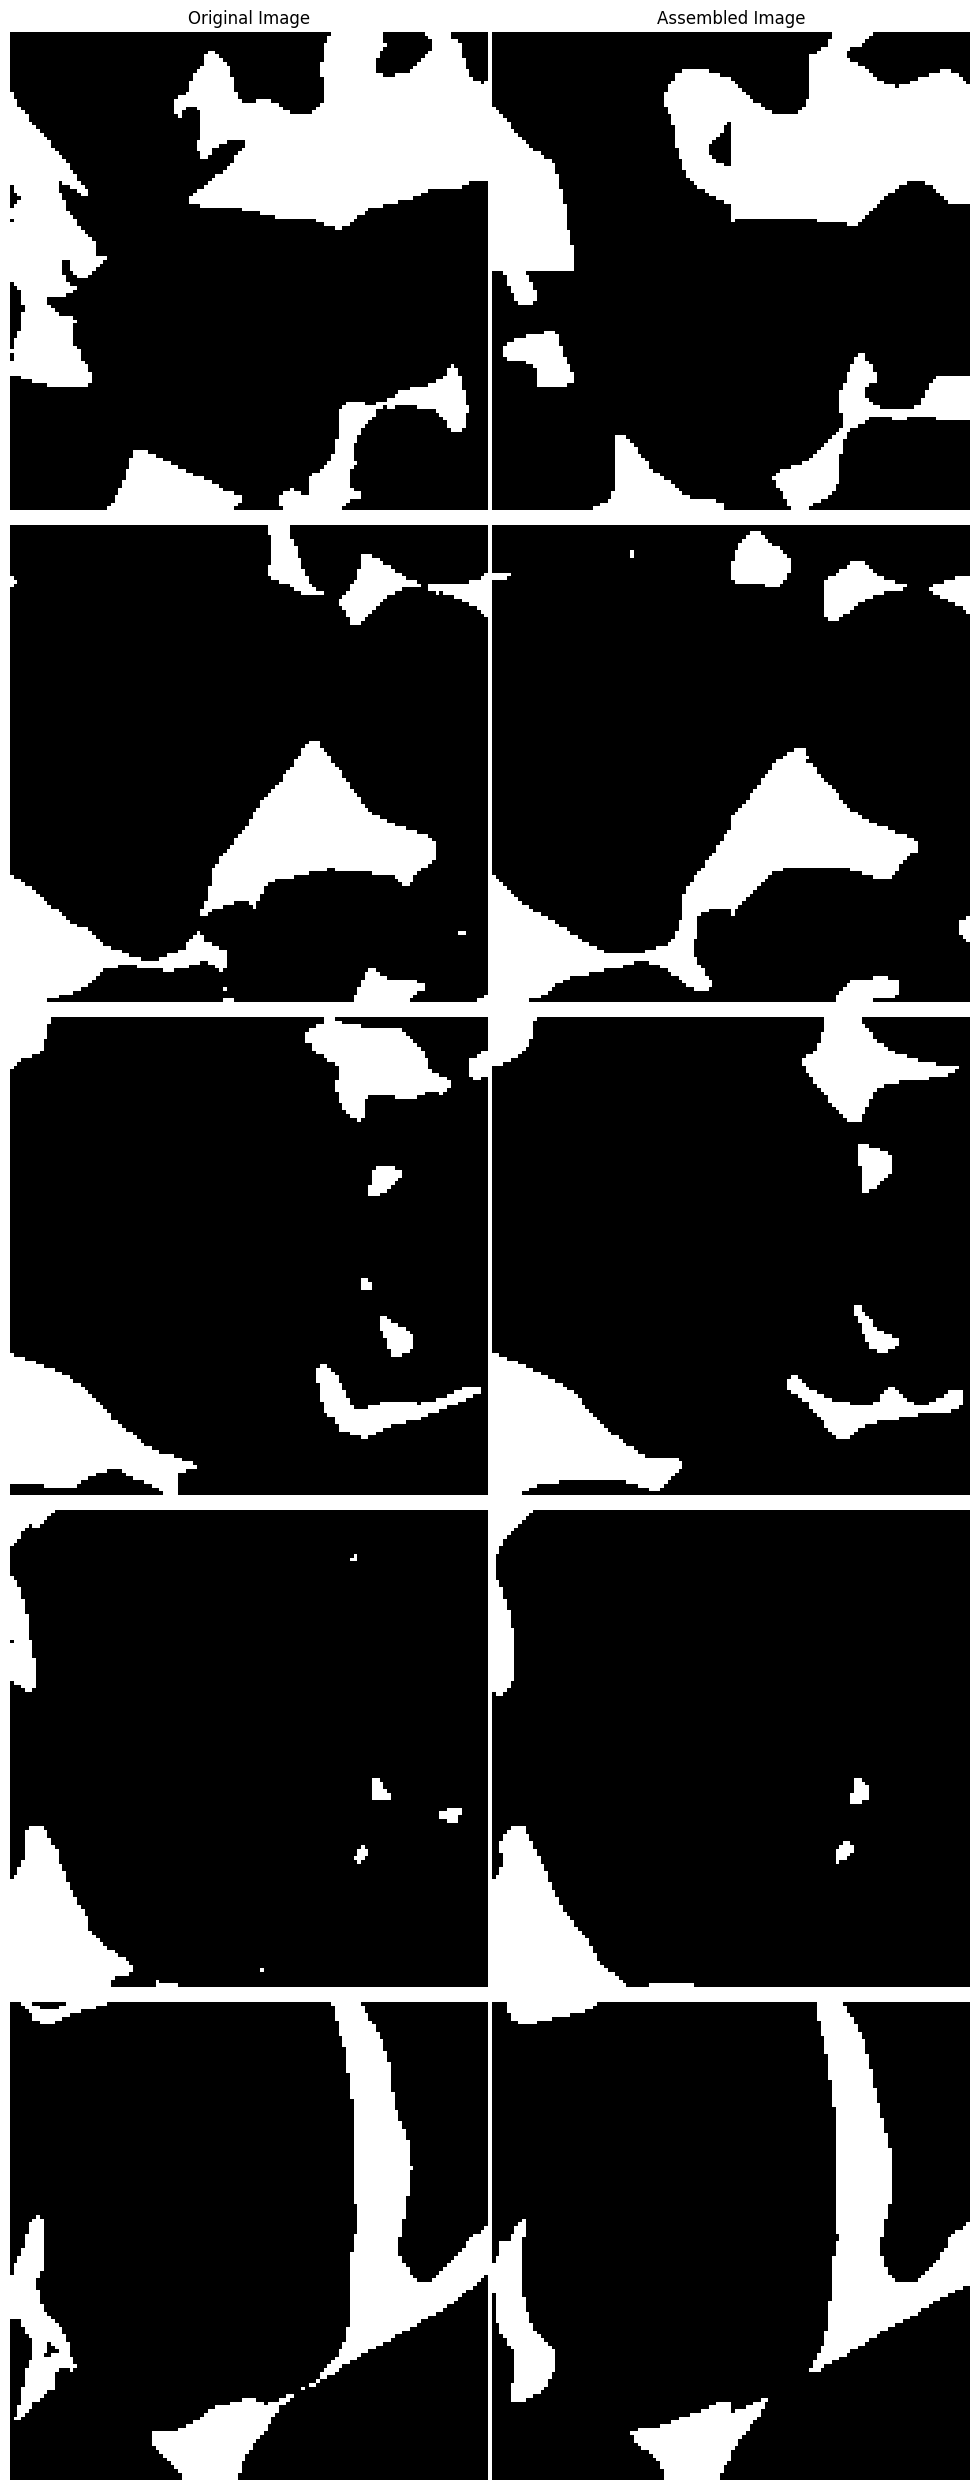

In [16]:
plot_image_comparison(img, img_assemble,[0,40,60,80,100])
